# GPROF GMI retrieval example

This notebook runs the QRNN GPROF retrieval on a GPROF preprocessor input file and compares the result to the current GPROF algorithm.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from regn.gprof import InputData
from regn.data.csu.training_data import GPROFDataset
training_data = GPROFDataset("/home/simon/src/regn/data/gprof_gmi_data_00.nc")

In [2]:
from regn.data.csu.retrieval import RetrievalFile
retrieval_file = RetrievalFile("/home/simon/scratch/2A.GCORE.GMI.V7.20190101-S001447-E014719.027510.BIN.gz")
reference_data = retrieval_file.to_xarray_dataset()

In [3]:
from regn.gprof import InputData
normalizer = training_data.normalizer
input_data = InputData("/home/simon/scratch/GMI_190101_027510.pp",
                       normalizer,
                       scans_per_batch=retrieval_file.n_scans)

In [4]:
nn_input = input_data.get_batch(0)
nn_input = nn_input.reshape(input_data.n_scans, input_data.n_pixels, 40)

## Input data

## Training data

### Brightness temperatures

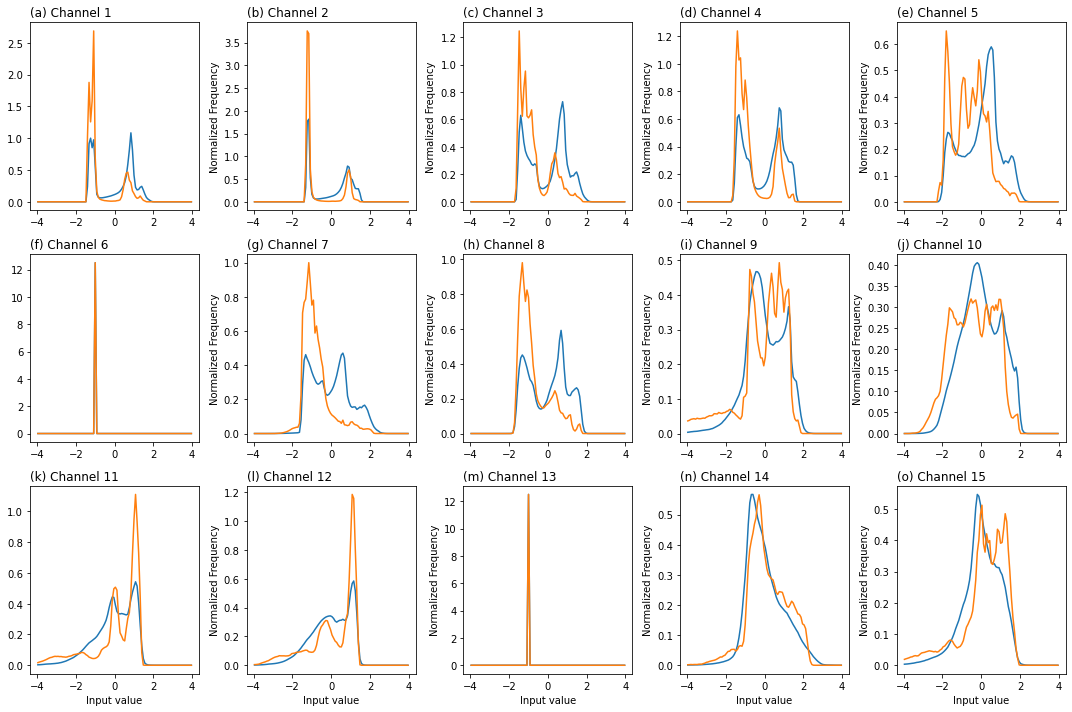

In [5]:
f, axs = plt.subplots(3, 5, figsize=(15, 10))
axs = axs.ravel()

bins = np.linspace(-4, 4, 101)
x = 0.5 * (bins[1:] + bins[:-1])

for i in range(15):
    ax = axs[i]
    
    y, _ = np.histogram(training_data.x[:, i], bins=bins, density=True)
    ax.plot(x, y)
    y, _ = np.histogram(nn_input[:, :, i].ravel(), bins=bins, density=True)
    ax.plot(x, y)
    
    ax.set_title(f"({chr(ord('a') + i)}) Channel {i + 1}", loc="left")
    if (i >= 10):
        ax.set_xlabel("Input value")
    if (i % 5):
        ax.set_ylabel("Normalized Frequency")
    
plt.tight_layout()

### Ancillary data

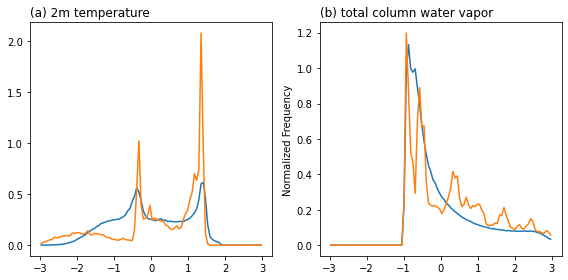

In [6]:
f, axs = plt.subplots(1, 2, figsize=(8, 4))
axs = axs.ravel()
titles = ["2m temperature", "total column water vapor"]
bins = np.linspace(-3, 3, 101)
x = 0.5 * (bins[1:] + bins[:-1])

for i in range(2):
    ax = axs[i]
    
    y, _ = np.histogram(training_data.x[:, 15 + i], bins=bins, density=True)
    ax.plot(x, y)
    y, _ = np.histogram(nn_input[:, :, 15 + i], bins=bins, density=True)
    ax.plot(x, y)
    
    ax.set_title(f"({chr(ord('a') + i)}) {titles[i]}", loc="left")
    if (i >= 10):
        ax.set_xlabel("Input value")
    if (i % 5):
        ax.set_ylabel("Normalized Frequency")
    
plt.tight_layout()

### Categorical data

In [7]:
x.shape

(100,)

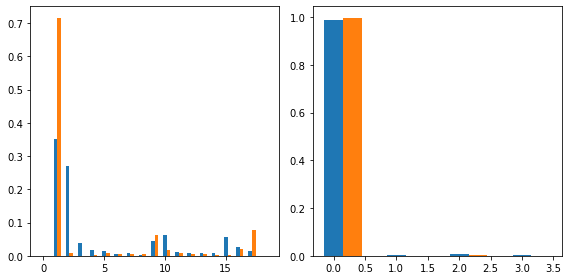

In [8]:
f, axs = plt.subplots(1, 2, figsize=(8, 4))
axs = axs.ravel()
titles = ["surface type", "air mass type"]
x = 0.5 * (bins[1:] + bins[:-1])

#
# Surface type
#

bins = np.linspace(-0.5, 19.5, 20)
x = np.arange(19)

types = np.where(training_data.x[:, 17:36])[1]
y, _ = np.histogram(types, bins=bins, density=True)
axs[0].bar(x, y, width=0.3)

types = np.where(nn_input[:, :, 17:36].reshape(-1, 19))[1]
y, _ = np.histogram(types, bins=bins, density=True)
axs[0].bar(x + 0.3, y, width=0.3)


bins = np.linspace(-0.5, 3.5, 5)
x = np.arange(4)

types = np.where(training_data.x[:, 36:])[1]
y, _ = np.histogram(types, bins=bins, density=True)
axs[1].bar(x, y, width=0.3)

types = np.where(nn_input[:, :, 36:].reshape(-1, 4))[1]
y, _ = np.histogram(types, bins=bins, density=True)
axs[1].bar(x + 0.3, y, width=0.3)

plt.tight_layout()

NameError: name 'result' is not defined

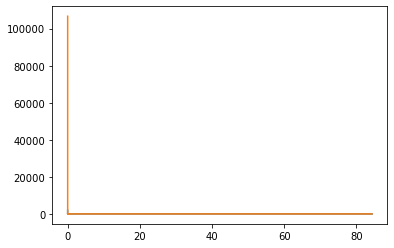

In [9]:
bins = np.logspace(-6, 2)
x = 0.5 * (bins[:-1] + bins[1:])
y, _ = np.histogram(reference_data["surface_precip"], bins=bins, density=True)
plt.plot(x, y)
y, _ = np.histogram(training_data.y, bins=bins, density=True)
plt.plot(x, y)
y, _ = np.histogram(result["posterior_mean"].data.ravel(), bins=bins, density=True)
plt.plot(x, y)
plt.xscale("log")


In [10]:
from quantnn import QRNN
qrnn = QRNN.load("/home/simon/src/regn/models/qrnn_gmi_12_256_relu_True_False.pt")

/home/simon/build/anaconda3/envs/py39/lib/python3.9/site-packages/torch/serialization.py:658: SourceChangeWarning: source code of class 'torch.nn.modules.container.ModuleList' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/simon/build/anaconda3/envs/py39/lib/python3.9/site-packages/torch/serialization.py:658: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/simon/build/anaconda3/envs/py39/lib/python3.9/site-packages/torch/serialization.py:658: SourceChangeWarning: source code of class 'torch.nn.modules.batchnorm.BatchNorm1d' has changed. you

In [12]:
del training_data

In [ ]:
results = input_data.run_retrieval(qrnn)

In [161]:
result

<xarray.Dataset>
Dimensions:              (n_pixels: 221, n_quantiles: 99, n_scans: 2962)
Dimensions without coordinates: n_pixels, n_quantiles, n_scans
Data variables:
    predicted_quantiles  (n_scans, n_pixels, n_quantiles) float64 0.4426 ... ...
    posterior_mean       (n_scans, n_pixels) float64 nan nan nan ... nan nan nan

In [191]:
y_pred = result["predicted_quantiles"][600:800, :, -1]

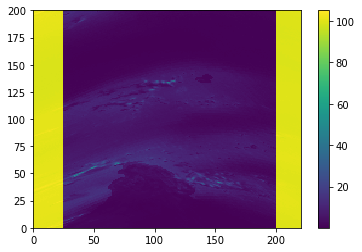

In [192]:
plt.pcolormesh(y_pred)
plt.colorbar()


In [16]:
mask = x[:, 0] < 0.0
y_pred =qrnn.predict(x[:, :17])
y_pred[mask] = np.nan


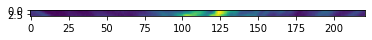

In [33]:
plt.imshow(x[:, 0].reshape(4, -1))

In [38]:
rf.n_pixels

221

In [36]:
from regn.data.csu.retrieval import RetrievalFile
rf = RetrievalFile("/home/simon/scratch/2A.GCORE.GMI.V7.20190101-S001447-E014719.027510.BIN.gz")
reference_data = rf.to_xarray_dataset()

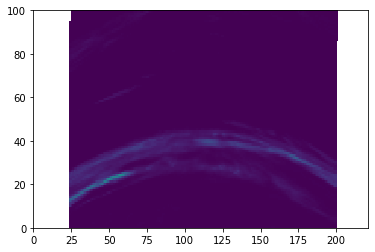

In [24]:
from matplotlib.colors import LogNorm, Normalize
precip = reference_data["surface_precip"].data[:]
mask = precip < 0.0
precip[precip < 0.0] = np.nan
plt.pcolormesh(precip[300:400], norm=Normalize(0.0, 10.0))


In [165]:
precip_qrnn = result["predicted_quantiles"].data[:, :, 49]
precip_gprof = reference_data["surface_precip"].data[:]
mask = precip_gprof < 0.0
precip_gprof[mask] = np.nan
precip_qrnn[mask] = np.nan

## Comparison to GPROF

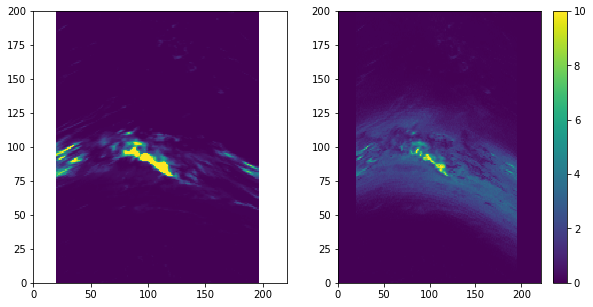

In [225]:
from matplotlib.colors import Normalize
f, axs = plt.subplots(1, 2, figsize=(10, 5))
norm = Normalize(0, 10)


axs[0].pcolormesh(precip_gprof[2100:2300, :], norm=norm)
img = axs[1].pcolormesh(precip_qrnn[2100:2300, :], norm=norm)
plt.colorbar(img)

In [218]:
np.nanmax(tb)

275.79998779296875

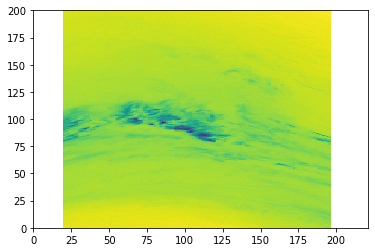

In [223]:
tb = input_data.data["brightness_temperatures"][2100:2300, :, -1][:].data
tb = tb[:]
tb[tb < 0.0] = np.nan
plt.pcolormesh(tb)

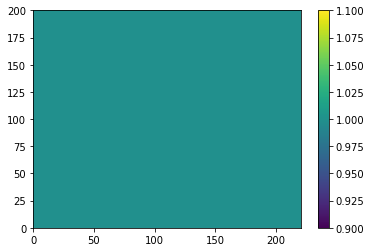

In [228]:
plt.pcolormesh(input_data.data["surface_type"][2100:2300, :])
plt.colorbar()

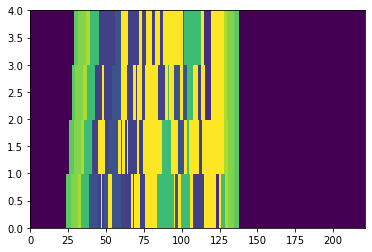

In [57]:
st = np.where(input_data.get_batch(150)[:, 17:36])[1]
plt.pcolormesh(st.reshape(4, -1))

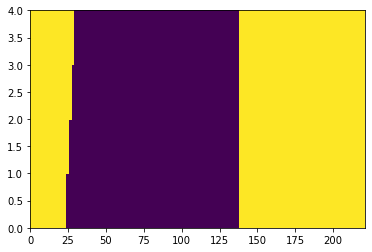

In [63]:
sea_flag = input_data.get_batch(150)[:, 18]
plt.pcolormesh(sea_flag.reshape(4, -1))

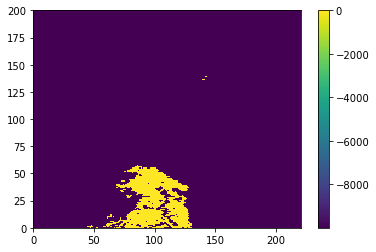

In [193]:
plt.pcolormesh(input_data.data["airmass_type"][600:800, :])
plt.colorbar()

In [194]:
training_data.x.shape

(8177175, 40)

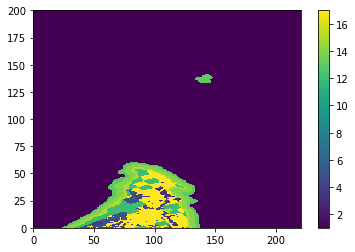

In [79]:
plt.pcolormesh(reference_data["surface_type_index"][600:800, :])
plt.colorbar()

In [89]:
input_data.data["airmass_type"].min()

<xarray.DataArray 'airmass_type' ()>
array(-9999.)

In [90]:
input_data.normalizer.means

{0: 219.0947598484637,
 1: 176.38591808771918,
 2: 229.3455690551859,
 3: 191.85418770710774,
 4: 240.01821386625784,
 5: -9999.486010702045,
 6: 238.32129168837187,
 7: 206.4422302761097,
 8: 253.0345000820348,
 9: 235.58904808002518,
 10: 259.4037505662024,
 11: 254.83719560007714,
 12: -9999.486010702045,
 13: 253.9894849194541,
 14: 259.8108766423622,
 15: 278.27702707921117,
 16: 15.946911056361992}

-20.25195